# Importing Models Types and Data

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from google.colab import drive
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

drive.mount('/content/drive')
customerData = pd.read_csv('drive/My Drive/customers.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
customerData.info()
customerData.describe()
customerData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [21]:
x = customerData[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

x = pd.get_dummies(x, columns=['Gender'], drop_first=True)

# Dimension Reduction Preprocessing

In [22]:
# Scale the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Create an X and Y commonent
n_components = 2

pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(x_scaled)

components_df = pd.DataFrame(data=pca.components_, columns=['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
print(components_df)

    Gender       Age  Annual Income (k$)  Spending Score (1-100)
0  0.68790 -0.006082           -0.686920                0.234302
1 -0.10369  0.765252            0.103211                0.626886


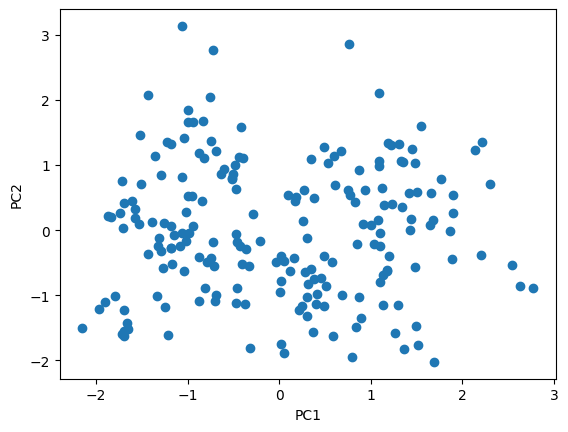

In [23]:
# Create a DataFrame
pca_df = pd.DataFrame(data=x_pca, columns=['PC1', 'PC2'])

# Graph
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# KMeans

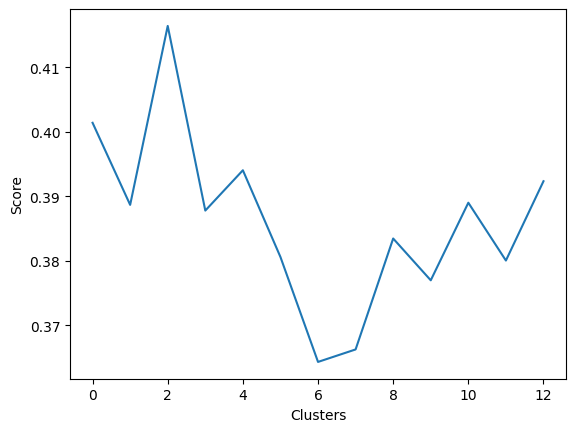

Clusters: 4


In [24]:
# Determine the best amount of clusters
silhouette_scores = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(x_pca)
    silhouette_scores.append(silhouette_score(x_pca, labels))

plt.plot(silhouette_scores)
plt.xlabel('Clusters')
plt.ylabel('Score')
plt.show()

best_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Clusters: {best_clusters}")

In [25]:
# Perform kMean with best cluster amount
kMean = Pipeline([
    ("kmeans", KMeans(n_clusters=best_clusters, random_state=42)),
])

kMean.fit(x_pca)

Pipeline(steps=[('kmeans', KMeans(n_clusters=4, random_state=42))])

In [26]:
labels = kMean.named_steps['kmeans'].labels_

customerData['kMeanCluster'] = labels

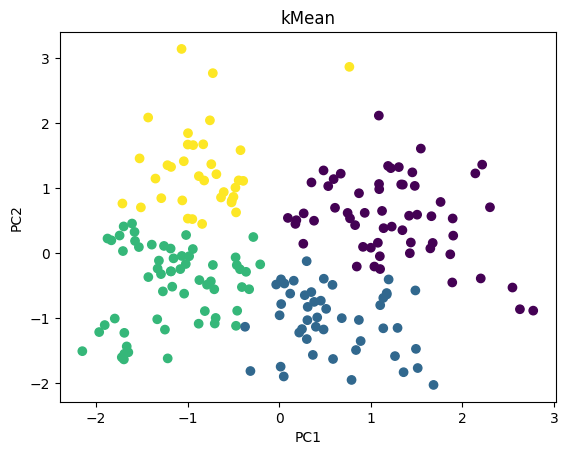

In [27]:
# Graph the kMean Clusters
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=customerData['kMeanCluster'], cmap='viridis')
plt.title('kMean')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [29]:
# Print the kMean Cluster's means
kmean_means = customerData.groupby('kMeanCluster').agg({col: 'mean' for col in customerData.select_dtypes(include=['number']).columns})

print(kmean_means)

              CustomerID        Age  Annual Income (k$)  \
kMeanCluster                                              
0             123.189655  49.068966           70.344828   
1              64.808511  47.680851           45.212766   
2              79.733333  27.233333           49.983333   
3             146.428571  29.971429           83.085714   

              Spending Score (1-100)  kMeanCluster  
kMeanCluster                                        
0                          28.568966           0.0  
1                          37.808511           1.0  
2                          67.933333           2.0  
3                          72.285714           3.0  


Based on the data collected here, my recommendation would be these groups:
- Women around the age of 27 with an annual income of around \$50k and a spending score around 67%. This group would be best to be targetted with luxury brand goods such as lululemon.
- Men around the age of 50 with an annual income around \$75k and a spending score around 30%. This group should be targetted with some form of home improvement items such as power tools, gardening equipment, or home security items.
- Women around the age of 50 with an annual income around \$46k and a spending score of 34%. This group is better targetted with mid-level  home decor items such as pictures, large tchotchke, and other decorative items.
- Men around the age of 30 with an annual income around \$80k and a spending score of 74%. I would target this group with tech related items such as new phones and tech equipment.

#DB Scan

In [30]:
# Determine the Best DB Scan criteria
best_eps, best_min_samples, best_silhouette_score = None, None, -1

for eps in np.arange(0.1, 1.1, 0.1):
    for min_samples in range(2, 20):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(x_scaled)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if num_clusters > 1:
            silhouette_avg = silhouette_score(x_scaled, labels)

            print(f"eps={eps}, min_samples={min_samples}, Silhouette Score: {silhouette_avg}")

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps, best_min_samples = eps, min_samples

print(f"Best Parameters - eps: {best_eps}, min_samples: {best_min_samples}, Silhouette Score: {best_silhouette_score}")

eps=0.1, min_samples=2, Silhouette Score: -0.18261786641059707
eps=0.2, min_samples=2, Silhouette Score: -0.2982915625666879
eps=0.2, min_samples=3, Silhouette Score: -0.32285457961368336
eps=0.30000000000000004, min_samples=2, Silhouette Score: -0.034077229864089405
eps=0.30000000000000004, min_samples=3, Silhouette Score: -0.2257864756342657
eps=0.30000000000000004, min_samples=4, Silhouette Score: -0.28895225069811936
eps=0.4, min_samples=2, Silhouette Score: 0.1108658688459716
eps=0.4, min_samples=3, Silhouette Score: -0.00467766560663776
eps=0.4, min_samples=4, Silhouette Score: -0.12235017475319783
eps=0.4, min_samples=5, Silhouette Score: -0.20528852634614722
eps=0.4, min_samples=6, Silhouette Score: -0.1408945206711457
eps=0.4, min_samples=7, Silhouette Score: -0.18201630089429813
eps=0.5, min_samples=2, Silhouette Score: 0.23886669798227914
eps=0.5, min_samples=3, Silhouette Score: 0.21460367830515828
eps=0.5, min_samples=4, Silhouette Score: 0.12061976322280465
eps=0.5, min_s

In [31]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_dbscan = dbscan.fit_predict(x_scaled)
customerData['dbScanCluster'] = labels_dbscan
dbscan.fit(x_scaled)

DBSCAN(eps=0.9)

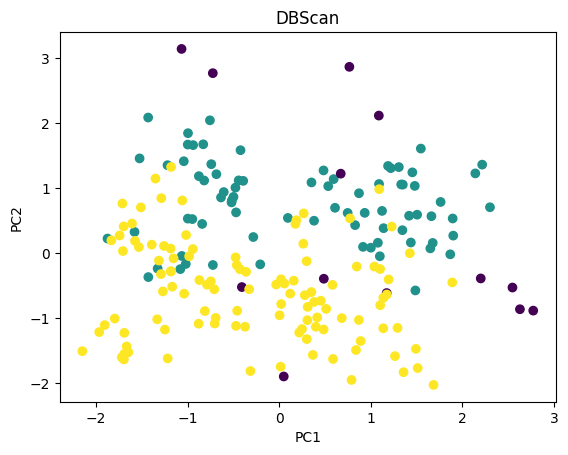

In [32]:
# Graph the DBScan
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=customerData['dbScanCluster'], cmap='viridis')
plt.title('DBScan')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [34]:
means_dbscan = customerData.groupby('dbScanCluster').mean(numeric_only=True)

print(means_dbscan)

               CustomerID        Age  Annual Income (k$)  \
dbScanCluster                                              
-1              85.461538  40.538462           62.692308   
 0             107.298701  39.493506           62.376623   
 1              97.518182  38.200000           59.036364   

               Spending Score (1-100)  kMeanCluster  
dbScanCluster                                        
-1                          25.307692      1.076923  
 0                          51.610390      1.285714  
 1                          52.154545      1.445455  


Based on the data collected here, my recommendation would be these groups:

- Men around the age of 40 with an annual income of around \$63k and a spending score around 25%. I would target someone in this group with a hobby related items such as sports store equipment.
- Men around the age of 40 with an annual income around \$62k and a spending score around 50%. I would target people in this group with similar things as the previous group, hobby related items, but I would do more expensive hobby related items such as tools for crafting things such as wood or leather carving tools.
- Women around the age of 40 with an annual income around \$59k and a spending score of 52%. I would target people in this group with more luxury brand clothing.


# Gaussian Mixture

In [35]:
n_components_range = range(2, 20)

In [36]:
# Determine the BIC score
bic_values = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(x_scaled)
    bic_values.append(gmm.bic(x_scaled))

BIC Component Number: 2


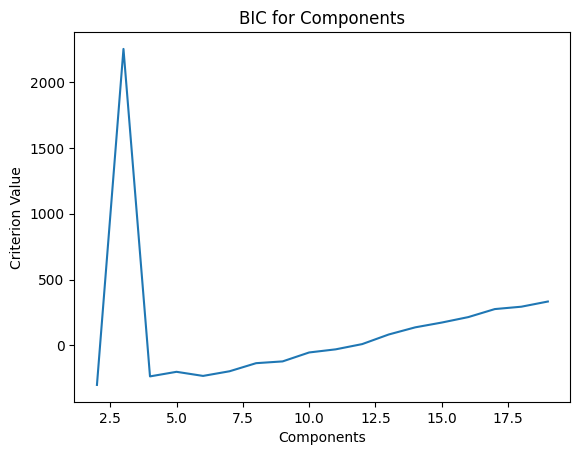

In [37]:
# Plot the BIC
plt.plot(n_components_range, bic_values)
plt.title('BIC for Components')
plt.xlabel('Components')
plt.ylabel('Criterion Value')

best_bic = n_components_range[np.argmin(bic_values)]

print(f"BIC Component Number: {best_bic}")

In [38]:
# Determine the AIC score
n_components_range = range(2, 15 + 1)

aic_values = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(x_scaled)
    aic_values.append(gmm.aic(x_scaled))

AIC Component Number: 12


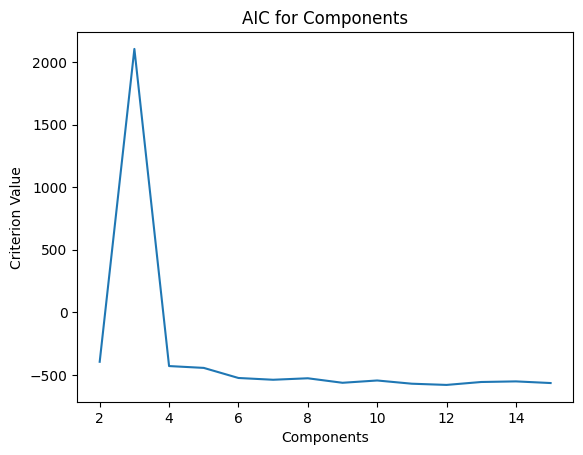

In [39]:
# Plot the AIC
plt.plot(n_components_range, aic_values)
plt.title('AIC for Components')
plt.xlabel('Components')
plt.ylabel('Criterion Value')

best_aic = n_components_range[np.argmin(aic_values)]

print(f"AIC Component Number: {best_aic}")

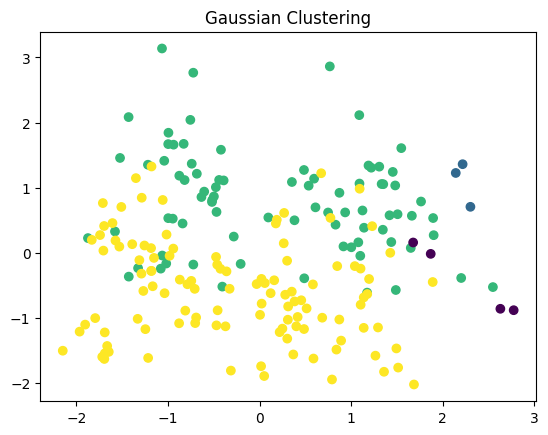

In [40]:
# Perform a Gaussian Mixture Model Clustering
gmm = GaussianMixture(n_components=4, random_state=42)
labels_gmm = gmm.fit_predict(x_scaled)

pca_df['gaussianCluster'] = labels_gmm

plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['gaussianCluster'], cmap='viridis')
plt.title('Gaussian Clustering')
plt.show()

In [41]:
# Print the mean of the Gaussian Clusters
original_df_gmm = pd.DataFrame(data=scaler.inverse_transform(pca.inverse_transform(x_pca)), columns=['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
original_df_gmm['gaussianCluster'] = labels_gmm


cluster_analysis_gmm_original = original_df_gmm.groupby('gaussianCluster').mean()

print(cluster_analysis_gmm_original)

                    Gender        Age  Annual Income (k$)  \
gaussianCluster                                             
0                60.873770  52.159419            9.547641   
1                58.547903  82.193808           13.828424   
2                39.577508  76.274527           48.850335   
3                37.009670  48.915573           53.602205   

                 Spending Score (1-100)  
gaussianCluster                          
0                              0.575343  
1                              1.039504  
2                              0.706981  
3                              0.226024  


Based on the data collected here, my recommendation would be these groups:

- Men around the age of 50 with an annual income of around \$72k and a spending score around 28%. This group should be targetted with cheaper home improvement items such as tools, or DIY home security items.
- People the age of 30 with an annual income around \$69k and a spending score around 69%. This group should probably be targetted with experiences such as massages, or
- Women around the age of 40 with an annual income around \$43k and a spending score of 49%. I would target people in this group with more luxury brand clothing.
- Men around the age of 30 with an annual income of around \$80k and a spending score around 68%. I would target this group with tech related items such as new phones and tech equipment.
